# Data Analysis

Analysis of bacterial data (wild type and mutants cells) with EfficientNet features and cell areas.

**Pipeline Overview:**
- **Step 1**: Pre-processing (merge data, add labels, filter low area, remove constant columns, outlier detection).
- **Step 2**: Subset selection.
- **Step 3**: Data scaling (standardize WT, save scaler).
- **Step 4**: PHATE
- **Step 5**: Angle aperture plot

In [2]:
import pandas as pd
import numpy as np
import os
import shutil
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import umap
import phate
import scanpy as sc
import scvelo as scv
from scipy.optimize import least_squares
from matplotlib.patches import Circle, Arc
from matplotlib.patches import Ellipse, Arc
import hdbscan

# Set plot style
sns.set_style('whitegrid')

# Create directories
os.makedirs('/scratch/leuven/359/vsc35907/big_data_feature_extraction/analysis/results/', exist_ok=True)

## Step 1: Pre-processing

In [3]:
import os
import pandas as pd
import numpy as np
import shutil

# Define paths
feature_file = '/scratch/leuven/359/vsc35907/big_data_feature_extraction/patches_dirs/features_model_lr_3e3_adamw_wd_1e5.csv'
area_file = '/scratch/leuven/359/vsc35907/big_data_feature_extraction/patches_dirs/area_cells.csv'
output_dir = '/scratch/leuven/359/vsc35907/big_data_feature_extraction/patches_dirs/clean_data'
garbage_dir = '/scratch/leuven/359/vsc35907/big_data_feature_extraction/analysis/garbage_cells'

# Create directories
os.makedirs(garbage_dir, exist_ok=True)
os.makedirs(output_dir, exist_ok=True)

# Define chunk size
chunk_size = 20000

# Helper functions
def normalize_path(path):
    """Normalize file paths to ensure consistency."""
    dirs = path.split("/")
    if len(dirs) == 3:
        path = '/scratch/leuven/359/vsc35907/big_data_feature_extraction/patches_dirs/' + path
    return path

def extract_batch(path):
    return int(os.path.basename(path).split()[0][:-3])

def extract_group(path):
    basename = os.path.basename(path)
    directory = os.path.dirname(path)
    pieces = basename.split()
    if len(pieces) == 5:
        group = pieces[3]
    else:
        group = pieces[2]
    return int(group)

def process_and_save(df, key, gene_mapping, output_dir):   
    
    # Add gene info
    df['gene'] = np.where(
        df['label'] == 1,
        df['group'].map(gene_mapping),
        np.nan
    )

    # Save to file
    if not df.empty:
        output_file = os.path.join(output_dir, f"clean_{key[0]}_{key[1]}_{key[2]}.csv")
        df.to_csv(
            output_file,
            mode='a',  # append if file exists
            header=not os.path.exists(output_file),  # write header only if file does not exist
            index=False
        )
        print(f"Saved combination {key} to {output_file}, Shape: {df.shape}")
    else:
        print(f"Combination {key} has no rows after preprocessing, skipping save")

In [5]:
# Load gene mapping
gene_df = pd.read_csv('/data/leuven/359/vsc35907/EfficientNet_feature_extraction/mutant_names.csv')
gene_mapping = gene_df.set_index('group')['gene'].to_dict()

# Build area dictionary with normalized paths
area_dict = {}
for area_chunk in pd.read_csv(area_file, chunksize=chunk_size):
    for _, row in area_chunk.iterrows():
        area_dict[normalize_path(row['image_path'])] = row['area']
print(f"Built area_dict with {len(area_dict)} entries")

# Initialize accumulators
combo_dfs = {}
prev_combos = set()

# Process feature file in chunks
for i, feature_chunk in enumerate(pd.read_csv(feature_file, chunksize=chunk_size)):
    
    print(f"\nProcessing chunk {i+1}...")
    
    # if i < 20:
    #     continue
    
    # Normalize image_path in feature_chunk
    feature_chunk['image_path'] = feature_chunk['image_path'].apply(normalize_path)

    # Merge with area data
    feature_chunk['area'] = feature_chunk['image_path'].map(area_dict)

    # Debug: Check for unmatched image_path
    unmatched = feature_chunk[feature_chunk['area'].isna()]['image_path']
    if not unmatched.empty:
        print(f"Warning: {len(unmatched)} unmatched image_path in chunk {i+1}. Sample: {unmatched.iloc[:5].tolist()}")

    
    print(f"Removing rows with any NaN, shape: {feature_chunk.shape}")
    feature_chunk = feature_chunk.dropna()
    print(f"After removing rows with any NaN, shape: {feature_chunk.shape}")

    # Warn if all rows were removed
    if feature_chunk.empty:
        print(f"Warning: All rows removed in chunk {i+1}. Check data consistency.")
        continue

    # Add metadata
    feature_chunk['label'] = feature_chunk['image_path'].apply(lambda x: 1 if 'mutant' in x.lower() else 0)
    feature_chunk['batch'] = feature_chunk['image_path'].apply(extract_batch)
    feature_chunk['group'] = feature_chunk['image_path'].apply(extract_group)

    # Move image_path to end
    image_path = feature_chunk.pop('image_path')
    feature_chunk['image_path'] = image_path

    # Remove garbage cells
    garbage_df = feature_chunk[feature_chunk['area'] <= 270]
    for img in garbage_df['image_path']:
        shutil.copy2(img, os.path.join(garbage_dir, os.path.basename(img)))
    feature_chunk = feature_chunk[feature_chunk['area'] > 270]
    print(f"Removed {len(garbage_df)} low-area cells in chunk {i+1}")
    print(f"Shape: {feature_chunk.shape}")

    # Group by combination
    grouped = feature_chunk.groupby(['label', 'batch', 'group'])
    current_combos = set(grouped.groups.keys())

    # Accumulate data
    for key, group_df in grouped:
        if key in combo_dfs:
            combo_dfs[key] = pd.concat([combo_dfs[key], group_df])
        else:
            combo_dfs[key] = group_df.copy()

    # Process completed combinations
    completed_combos = prev_combos - current_combos
    for key in completed_combos:
        process_and_save(combo_dfs[key], key, gene_mapping, output_dir)
        del combo_dfs[key]
    prev_combos = current_combos
    print(f"Chunk {i+1} processed, active combinations: {len(combo_dfs)}")

# Process remaining combinations
for key in list(combo_dfs.keys()):
    process_and_save(combo_dfs[key], key, gene_mapping, output_dir)
    del combo_dfs[key]

print("Preprocessing complete. Cleaned files saved in", output_dir)

Built area_dict with 1057609 entries

Processing chunk 1...
Removing rows with any NaN, shape: (20000, 1282)
After removing rows with any NaN, shape: (20000, 1282)
Removed 302 low-area cells in chunk 1
Shape: (19698, 1285)
Chunk 1 processed, active combinations: 9

Processing chunk 2...
Removing rows with any NaN, shape: (20000, 1282)
After removing rows with any NaN, shape: (20000, 1282)
Removed 102 low-area cells in chunk 2
Shape: (19898, 1285)
Saved combination (1, 190425, 57) to /scratch/leuven/359/vsc35907/big_data_feature_extraction/patches_dirs/clean_data/clean_1_190425_57.csv, Shape: (181, 1286)
Saved combination (1, 190425, 99) to /scratch/leuven/359/vsc35907/big_data_feature_extraction/patches_dirs/clean_data/clean_1_190425_99.csv, Shape: (2706, 1286)
Saved combination (1, 190425, 114) to /scratch/leuven/359/vsc35907/big_data_feature_extraction/patches_dirs/clean_data/clean_1_190425_114.csv, Shape: (1139, 1286)
Saved combination (1, 190425, 56) to /scratch/leuven/359/vsc35907

In [4]:
# DELETES ALL THE CSV FILES IN THE OUTPUT DIRECTORY!!!!!!!!!!
# DO NOT RUN THIS CELL!!! I REPET: DO NOT RUN THIS CELL!!!!!!

# import os

# for filename in os.listdir(output_dir):
#     file_path = os.path.join(output_dir, filename)
#     if os.path.isfile(file_path):
#         os.remove(file_path)
# print(os.listdir(output_dir))

[]


##### Check csv files shape

In [ ]:
files = os.listdir(output_dir)
files = [f for f in files if '.csv' in f]
print(f'total csv files found: {len(files)}')
for filename in files:
    file_path = os.path.join(output_dir, filename)
    if os.path.isfile(file_path):
        df = pd.read_csv(file_path)
        print(f'file: {os.path.basename(file_path)} shape: {df.shape}')  # Remove the parentheses
#print(os.listdir(output_dir))

## Steps 2-7: Subset Selection, Normalization, Outliers Filtering, PHATE, and Aperture Analysis

In [2]:
def fit_ellipse(points):
    """Fit an ellipse to 2D points using least-squares optimization."""
    def ellipse_residuals(params, x, y):
        xc, yc, a, b, theta = params
        cos_theta, sin_theta = np.cos(theta), np.sin(theta)
        x_rot = cos_theta * (x - xc) + sin_theta * (y - yc)
        y_rot = -sin_theta * (x - xc) + cos_theta * (y - yc)
        return (x_rot / a)**2 + (y_rot / b)**2 - 1

    x, y = points[:, 0], points[:, 1]
    xc_guess, yc_guess = np.mean(x), np.mean(y)
    a_guess = np.std(x) * 2
    b_guess = np.std(y) * 2
    theta_guess = 0.0
    initial_guess = [xc_guess, yc_guess, a_guess, b_guess, theta_guess]

    bounds = ([-np.inf, -np.inf, 0, 0, -np.pi], [np.inf, np.inf, np.inf, np.inf, np.pi])
    
    result = least_squares(ellipse_residuals, initial_guess, args=(x, y), bounds=bounds)
    xc, yc, a, b, theta = result.x
    return xc, yc, a, b, theta

def compute_aperture_angle(points, xc, yc, theta):
    """Compute the aperture angle and its start/end angles in the ellipse's coordinate system."""
    # Shift points relative to center
    x, y = points[:, 0] - xc, points[:, 1] - yc
    
    # Rotate points to ellipse's coordinate system (undo ellipse rotation)
    cos_theta, sin_theta = np.cos(-theta), np.sin(-theta)
    x_rot = cos_theta * x + sin_theta * y
    y_rot = -sin_theta * x + cos_theta * y
    angles = np.arctan2(y_rot, x_rot)
    
    # Now angles are in DEGREES!
    angles = np.degrees(angles)
    
    # Sort angles and compute differences
    angles = np.sort(angles)
    angle_diffs = np.diff(angles)
    wrap_diff = 360 + angles[0] - angles[-1]
    angle_diffs = np.append(angle_diffs, wrap_diff)
    
    # Find the largest gap (aperture)
    gap_idx = np.argmax(angle_diffs)
    aperture_angle = angle_diffs[gap_idx]
    
    # Determine start and end angles in ellipse's coordinate system
    if gap_idx < len(angles):
        start_angle_ellipse = angles[gap_idx]
        end_angle_ellipse = angles[gap_idx] + aperture_angle
    else:
        start_angle_ellipse = angles[-1]
        end_angle_ellipse = angles[0] + 360
    
    # Convert to degrees for visualization
    aperture_angle_deg = aperture_angle % 360
    start_angle_ellipse_deg = start_angle_ellipse % 360
    end_angle_ellipse_deg = end_angle_ellipse % 360
    
    return aperture_angle_deg, start_angle_ellipse_deg, end_angle_ellipse_deg

# def visualize_horseshoe(points, areas, cell_stages, xc, yc, a, b, theta, aperture_angle, start_angle, end_angle, batch, group, label_str, save_dir):
#     """Visualize the points, fitted ellipse, center, and aperture angle, with points colored by cell_stage (non-NaN) and area."""
#     fig, ax = plt.subplots(figsize=(8, 8))
    
#     # Plot points colored by area (all points)
#     sc_area = ax.scatter(points[:, 0], points[:, 1], c=areas, s=50, alpha=0.3, cmap='viridis', label='Area')
#     plt.colorbar(sc_area, label='Area', shrink=0.7)
    
#     # Plot points colored by cell_stage (non-NaN only)
#     cell_stages = np.array(cell_stages)
#     non_nan_mask = ~pd.isna(cell_stages)
#     if non_nan_mask.sum() > 0:
#         # Define custom colors for cell stages B, C, D
#         stage_dict = {
#             'B': '#03ecfc',  
#             'C': '#7bfc03',   
#             'D': '#fc03d3'    
#         }
#         unique_stages = np.unique(cell_stages[non_nan_mask])
        
#         for stage in unique_stages:
#             if stage in stage_dict:  # Ensure stage is one of B, C, D
#                 stage_mask = (cell_stages == stage) & non_nan_mask
#                 ax.scatter(
#                     points[stage_mask, 0], points[stage_mask, 1],
#                     c=[stage_dict[stage]], s=50, label=f'Cell Stage {stage}', alpha=0.8
#                 )
    
#     # Draw fitted ellipse
#     ellipse = Ellipse(
#         (xc, yc), 2 * a, 2 * b, angle=np.degrees(theta),
#         fill=False, color='red', linestyle='--', label='Fitted ellipse'
#     )
#     ax.add_patch(ellipse)
    
#     # Mark center
#     ax.scatter([xc], [yc], c='green', s=100, marker='x', label='Center')
    
#     # Draw aperture arc
#     arc = Arc(
#         (xc, yc), 2 * a * 0.8, 2 * b * 0.8,
#         angle=np.degrees(theta),
#         theta1=start_angle, theta2=end_angle,
#         color='purple', linestyle='-', linewidth=2, label=f'Aperture ({aperture_angle:.1f}°)'
#     )
#     ax.add_patch(arc)
    
#     # Set plot properties
#     ax.set_aspect('equal')
#     ax.set_xlabel('PHATE 1')
#     ax.set_ylabel('PHATE 2')
#     ax.legend(
#         bbox_to_anchor=(0.5, -0.15), loc='upper center',
#         ncol=4, frameon=False
#     )
#     ax.grid(True, alpha=0.3)
#     plt.title(f'Horseshoe Plot: Label {label_str} Batch {batch}, Group {group}')
    
#     # Save the plot
#     plot_path = os.path.join(save_dir, f'horseshoe_label_{label_str}_batch_{batch}_group_{group}.png')
#     plt.savefig(plot_path, bbox_inches='tight', dpi=300)
#     plt.close()

def visualize_horseshoe(points, areas, cell_stages, xc, yc, a, b, theta, aperture_angle, start_angle, end_angle, batch, group, label_str, save_dir):
    """Visualize PHATE points colored by area with equal axis intervals.

    Parameters:
    - points: numpy array of shape (n, 2) with PHATE coordinates.
    - areas: numpy array of shape (n,) with area values for coloring points.
    - cell_stages: numpy array of shape (n,) with cell stage labels (not used in this version).
    - xc, yc, a, b, theta, aperture_angle, start_angle, end_angle: parameters not used in this simplified version.
    - batch, group, label_str: strings, identifiers for the plot title and filename.
    - save_dir: string, directory to save the plot.
    """
    # Create a new figure and axis
    fig, ax = plt.subplots(figsize=(8, 8))

    # Plot PHATE points colored by area
    sc = ax.scatter(points[:, 0], points[:, 1], c=areas, s=50, alpha=0.3, cmap='viridis', label='Area')

    # Determine the range for both axes based on the data
    data_min = np.min(points)
    data_max = np.max(points)
    padding = (data_max - data_min) * 0.1  # Add 10% padding
    axis_limit_min = data_min - padding
    axis_limit_max = data_max + padding

    # Set equal axis limits
    ax.set_xlim(axis_limit_min, axis_limit_max)
    ax.set_ylim(axis_limit_min, axis_limit_max)

    # Add a colorbar for the area values
    plt.colorbar(sc, label='Area', shrink=0.7)

    # Set plot properties
    ax.set_aspect('equal')  # Ensure equal scaling on axes
    ax.set_xlabel('PHATE 1')
    ax.set_ylabel('PHATE 2')

    # Add a title
    plt.title(f'Horseshoe Plot: Label {label_str}, Batch {batch}, Group {group}')

    # Optimize layout
    plt.tight_layout()

    # Save the plot
    os.makedirs(save_dir, exist_ok=True)
    plot_path = os.path.join(save_dir, f'horseshoe_label_{label_str}_batch_{batch}_group_{group}.png')
    plt.savefig(plot_path, bbox_inches='tight', dpi=300)
    plt.close()

def analyze_horseshoe(points, areas, cell_stages, batch, group, label_str, save_dir):
    """Analyze a horseshoe-shaped data cloud and save visualization."""
    if not isinstance(points, np.ndarray) or points.shape[1] != 2:
        raise ValueError("Input must be a NumPy array with shape (n, 2)")
    
    xc, yc, a, b, theta = fit_ellipse(points)
    aperture_angle, start_angle, end_angle = compute_aperture_angle(points, xc, yc, theta)
    visualize_horseshoe(points, areas, cell_stages, xc, yc, a, b, theta, aperture_angle, start_angle, end_angle, batch, group, label_str, save_dir)
    
    return {
        'center': (xc, yc),
        'semi_major_axis': a,
        'semi_minor_axis': b,
        'rotation_angle_deg': np.degrees(theta),
        'aperture_angle_deg': aperture_angle,
        'start_angle_deg': start_angle,
        'end_angle_deg': end_angle
    }

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import os
from scipy.optimize import least_squares
import pandas as pd
from matplotlib.patches import Arc as MplArc

def fit_parabola(points):
    """Fit a parabolic arc (y = ax^2 + bx + c) to 2D points using least-squares."""
    def parabola_residuals(params, x, y):
        a, b, c = params
        y_pred = a * x**2 + b * x + c
        return y - y_pred

    x, y = points[:, 0], points[:, 1]
    # Initial guess: simple quadratic fit
    xc, yc = np.mean(x), np.mean(y)
    a_guess = 0.1  # Small curvature
    b_guess = 0.0  # No initial slope
    c_guess = yc - a_guess * xc**2  # Intercept at centroid
    initial_guess = [a_guess, b_guess, c_guess]

    result = least_squares(parabola_residuals, initial_guess, args=(x, y))
    a, b, c = result.x
    return xc, yc, a, b, c

def compute_arc_lenght:
    
def compute_width:
    
def compute_height:
    
def compute_center: 

def visualize_horseshoe():
    """Visualize PHATE points colored by area and cell stage, with fitted parabolic arc."""
    fig, ax = plt.subplots(figsize=(8, 8))
    
    # Plot points colored by area
    sc_area = ax.scatter(points[:, 0], points[:, 1], c=areas, s=50, alpha=0.3, cmap='viridis', label='Area')
    plt.colorbar(sc_area, label='Area', shrink=0.7)
    
    # Plot points colored by cell_stage (non-NaN only)
    cell_stages = np.array(cell_stages)
    non_nan_mask = ~pd.isna(cell_stages)
    if non_nan_mask.sum() > 0:
        stage_dict = {
            'B': '#03ecfc',  
            'C': '#7bfc03',   
            'D': '#fc03d3'    
        }
        unique_stages = np.unique(cell_stages[non_nan_mask])
        
        for stage in unique_stages:
            if stage in stage_dict:
                stage_mask = (cell_stages == stage) & non_nan_mask
                ax.scatter(
                    points[stage_mask, 0], points[stage_mask, 1],
                    c=[stage_dict[stage]], s=50, label=f'Cell Stage {stage}', alpha=0.8
                )
    
    # Draw fitted parabolic arc
    x_range = np.linspace(np.min(points[:, 0]), np.max(points[:, 0]), 100)
    y_parabola = a * x_range**2 + b * x_range + c
    ax.plot(x_range, y_parabola, color='red', linestyle='--', linewidth=2, label='Fitted parabola')
    
    # Mark centroid
    ax.scatter([xc], [yc], c='green', s=100, marker='x', label='Centroid')
    
    # Draw aperture arc (using centroid as reference)
    # Estimate radius as average distance from centroid to points
    distances = np.sqrt((points[:, 0] - xc)**2 + (points[:, 1] - yc)**2)
    r = np.mean(distances)
    arc_aperture = MplArc(
        (xc, yc), 2 * r * 0.8, 2 * r * 0.8,
        theta1=start_angle, theta2=end_angle,
        color='purple', linestyle='-', linewidth=2, label=f'Aperture ({aperture_angle:.1f}°)'
    )
    ax.add_patch(arc_aperture)
    
    # Set plot properties
    data_min = np.min(points)
    data_max = np.max(points)
    padding = (data_max - data_min) * 0.1
    axis_limit_min = data_min - padding
    axis_limit_max = data_max + padding
    ax.set_xlim(axis_limit_min, axis_limit_max)
    ax.set_ylim(axis_limit_min, axis_limit_max)
    
    ax.set_aspect('equal')
    ax.set_xlabel('PHATE 1')
    ax.set_ylabel('PHATE 2')
    ax.legend(bbox_to_anchor=(0.5, -0.15), loc='upper center', ncol=4, frameon=False)
    ax.grid(True, alpha=0.3)
    plt.title(f'Horseshoe Plot: Label {label_str}, Batch {batch}, Group {group}')
    
    # Save the plot
    os.makedirs(save_dir, exist_ok=True)
    plot_path = os.path.join(save_dir, f'horseshoe_label_{label_str}_batch_{batch}_group_{group}.png')
    plt.savefig(plot_path, bbox_inches='tight', dpi=300)
    plt.close()

def analyze_horseshoe(points, areas, cell_stages, batch, group, label_str, save_dir):
    """Analyze a horseshoe-shaped data cloud and save visualization."""
    if not isinstance(points, np.ndarray) or points.shape[1] != 2:
        raise ValueError("Input must be a NumPy array with shape (n, 2)")
    
    xc, yc, a, b, c = fit_parabola(points)
    aperture_angle, start_angle, end_angle = compute_aperture_angle(points, xc, yc, a, b, c)
    visualize_horseshoe(points, areas, cell_stages, xc, yc, a, b, c, 0, aperture_angle, start_angle, end_angle, batch, group, label_str, save_dir)
    
    return {
        'centroid': (xc, yc),
        'parabola_coefficients': {'a': a, 'b': b, 'c': c},
        'aperture_angle_deg': aperture_angle,
        'start_angle_deg': start_angle,
        'end_angle_deg': end_angle
    }

In [8]:
import numpy as np
import matplotlib.pyplot as plt
import os
from scipy.interpolate import UnivariateSpline
import pandas as pd
from matplotlib.patches import Arc as MplArc
from sklearn.decomposition import PCA

def fit_spline(points):
    """Fit a cubic spline to 2D points, sorting by principal direction."""
    x, y = points[:, 0], points[:, 1]
    # Compute centroid
    xc, yc = np.mean(x), np.mean(y)
    
    # Use PCA to find principal direction for sorting
    pca = PCA(n_components=1)
    pca.fit(points)
    principal_axis = pca.components_[0]
    # Project points onto principal axis to sort them
    projections = points @ principal_axis
    sort_idx = np.argsort(projections)
    
    # Sort points by projection
    x_sorted = x[sort_idx]
    y_sorted = y[sort_idx]
    
    # Fit a cubic spline (y as a function of x)
    # Remove duplicates in x to avoid interpolation issues
    unique_idx = np.unique(x_sorted, return_index=True)[1]
    x_unique = x_sorted[unique_idx]
    y_unique = y_sorted[unique_idx]
    
    # Create spline with smoothing
    spline = UnivariateSpline(x_unique, y_unique, s=len(unique_idx), k=3)  # s controls smoothing
    
    return xc, yc, spline

def compute_aperture_angle(points, xc, yc, spline):
    """Compute the aperture angle and its start/end angles relative to centroid."""
    # Shift points relative to centroid
    x, y = points[:, 0] - xc, points[:, 1] - yc
    
    # Compute angles of points relative to centroid
    angles = np.arctan2(y, x)
    angles = np.degrees(angles)  # Convert to degrees
    
    # Sort angles and compute differences
    angles = np.sort(angles)
    angle_diffs = np.diff(angles)
    wrap_diff = 360 + angles[0] - angles[-1]
    angle_diffs = np.append(angle_diffs, wrap_diff)
    
    # Find the largest gap (aperture)
    gap_idx = np.argmax(angle_diffs)
    aperture_angle = angle_diffs[gap_idx]
    
    # Determine start and end angles
    if gap_idx < len(angles):
        start_angle = angles[gap_idx]
        end_angle = angles[gap_idx] + aperture_angle
    else:
        start_angle = angles[-1]
        end_angle = angles[0] + 360
    
    aperture_angle_deg = aperture_angle % 360
    start_angle_deg = start_angle % 360
    end_angle_deg = end_angle % 360
    
    return aperture_angle_deg, start_angle_deg, end_angle_deg

def visualize_horseshoe(points, areas, cell_stages, xc, yc, spline, theta, aperture_angle, start_angle, end_angle, batch, group, label_str, save_dir):
    """Visualize PHATE points colored by area and cell stage, with fitted spline."""
    fig, ax = plt.subplots(figsize=(8, 8))
    
    # Plot points colored by area
    sc_area = ax.scatter(points[:, 0], points[:, 1], c=areas, s=50, alpha=0.3, cmap='viridis', label='Area')
    plt.colorbar(sc_area, label='Area', shrink=0.7)
    
    # Plot points colored by cell_stage (non-NaN only)
    cell_stages = np.array(cell_stages)
    non_nan_mask = ~pd.isna(cell_stages)
    if non_nan_mask.sum() > 0:
        stage_dict = {
            'B': '#03ecfc',  
            'C': '#7bfc03',   
            'D': '#fc03d3'    
        }
        unique_stages = np.unique(cell_stages[non_nan_mask])
        
        for stage in unique_stages:
            if stage in stage_dict:
                stage_mask = (cell_stages == stage) & non_nan_mask
                ax.scatter(
                    points[stage_mask, 0], points[stage_mask, 1],
                    c=[stage_dict[stage]], s=50, label=f'Cell Stage {stage}', alpha=0.8
                )
    
    # Draw fitted spline
    x_range = np.linspace(np.min(points[:, 0]), np.max(points[:, 0]), 100)
    y_spline = spline(x_range)
    ax.plot(x_range, y_spline, color='red', linestyle='--', linewidth=2, label='Fitted spline')
    
    # Mark centroid
    ax.scatter([xc], [yc], c='green', s=100, marker='x', label='Centroid')
    
    # Draw aperture arc (using centroid as reference)
    # Estimate radius as average distance from centroid to points
    distances = np.sqrt((points[:, 0] - xc)**2 + (points[:, 1] - yc)**2)
    r = np.mean(distances)
    arc_aperture = MplArc(
        (xc, yc), 2 * r * 0.8, 2 * r * 0.8,
        theta1=start_angle, theta2=end_angle,
        color='purple', linestyle='-', linewidth=2, label=f'Aperture ({aperture_angle:.1f}°)'
    )
    ax.add_patch(arc_aperture)
    
    # Set plot properties
    data_min = np.min(points)
    data_max = np.max(points)
    padding = (data_max - data_min) * 0.1
    axis_limit_min = data_min - padding
    axis_limit_max = data_max + padding
    ax.set_xlim(axis_limit_min, axis_limit_max)
    ax.set_ylim(axis_limit_min, axis_limit_max)
    
    ax.set_aspect('equal')
    ax.set_xlabel('PHATE 1')
    ax.set_ylabel('PHATE 2')
    ax.legend(bbox_to_anchor=(0.5, -0.15), loc='upper center', ncol=4, frameon=False)
    ax.grid(True, alpha=0.3)
    plt.title(f'Horseshoe Plot: Label {label_str}, Batch {batch}, Group {group}')
    
    # Save the plot
    os.makedirs(save_dir, exist_ok=True)
    plot_path = os.path.join(save_dir, f'horseshoe_label_{label_str}_batch_{batch}_group_{group}.png')
    plt.savefig(plot_path, bbox_inches='tight', dpi=300)
    plt.close()

def analyze_horseshoe(points, areas, cell_stages, batch, group, label_str, save_dir):
    """Analyze a horseshoe-shaped data cloud and save visualization."""
    if not isinstance(points, np.ndarray) or points.shape[1] != 2:
        raise ValueError("Input must be a NumPy array with shape (n, 2)")
    
    xc, yc, spline = fit_spline(points)
    aperture_angle, start_angle, end_angle = compute_aperture_angle(points, xc, yc, spline)
    visualize_horseshoe(points, areas, cell_stages, xc, yc, spline, 0, aperture_angle, start_angle, end_angle, batch, group, label_str, save_dir)
    
    return {
        'centroid': (xc, yc),
        'spline': 'Cubic spline fitted to sorted points',
        'aperture_angle_deg': aperture_angle,
        'start_angle_deg': start_angle,
        'end_angle_deg': end_angle
    }

In [14]:
def process_subset(df, feature_columns, label_str, batch, group, results_dir, outliers_excluded=True):
    """Process a subset of the DataFrame for a given label, batch, and group."""
    try:
        print(f"\nProcessing Label {label_str}, Batch {batch}, Group {group}...")
        if df.shape[0] < 100:
            print(f'Skipping Label {label_str}, Batch {batch}, Group {group}: Insufficient data fewer than 100 samples (n={df.shape[0]})')
            return None
        
        print(f'initial shape: {df.shape}')
        
        # Step 1: Initial Outlier Removal (moved from Step 2)
        features = df[feature_columns].values  # Get raw features before scaling
        inlier_mask_initial = np.all(np.abs((features - np.mean(features, axis=0)) / np.std(features, axis=0)) <= 12, axis=1)
        inlier_indices = df.index[inlier_mask_initial]
        features = features[inlier_mask_initial]
        print(f'shape after outliers removal: {features.shape}')

        # Step 2: Normalization (moved from Step 1)
        scaler = StandardScaler()
        features = scaler.fit_transform(features)
        
        if outliers_excluded:
            # Step 3: PCA 90%
            pca = PCA(n_components=0.90)
            reduced_data = pca.fit_transform(features)
            print(f'shape after pca: {reduced_data.shape}')
            
            # Step 4: HDBSCAN to filter outliers
            clusterer = hdbscan.HDBSCAN(min_cluster_size=10, min_samples=5)
            cluster_labels = clusterer.fit_predict(reduced_data)
            
            # Step 5: Filter out outliers
            inlier_mask_hdbscan = cluster_labels >= 0
            final_inlier_indices = inlier_indices[inlier_mask_hdbscan]
            filtered_features = features[inlier_mask_hdbscan]
            print(f'shape after HDBSCAN: {filtered_features.shape}')
        else:
            final_inlier_indices = inlier_indices
            filtered_features = features
            
        print(f'Final shape: {filtered_features.shape}')
        
        if len(filtered_features) < 100:
            print(f'Skipping Label {label_str}, Batch {batch}, Group {group}: Insufficient data after filtering (n={len(filtered_features)})')
            return None
        
        # Step 6: PHATE
        phate_op = phate.PHATE(n_components=2, random_state=42, n_jobs=-1, verbose=False)
        phate_data = phate_op.fit_transform(filtered_features)
        print(f'PHATE shape: {phate_data.shape}')
        unique_points = np.unique(phate_data, axis=0).shape[0]
        print(f"Number of unique PHATE points: {unique_points}")

        # Step 7: Select areas and cell_stages using final indices
        areas = df.loc[final_inlier_indices, 'area'].values
        cell_stages = df.loc[final_inlier_indices, 'cell_stage'].values
        print(f'areas shape: {areas.shape}')
        print(f'cell_stages shape: {cell_stages.shape}')

        # Step 8: Aperture analysis
        result = analyze_horseshoe(phate_data, areas, cell_stages, batch, group, label_str, results_dir)
        print(result)
        result.update({'batch': batch, 'group': group, 'label': label_str})
        
        print(f'Centroid: {result["centroid"]:.3f}')
        print(f'Spline: {result["spline"]:.2f}')
        print(f'Aperture Angle: {result["aperture_angle_deg"]:.2f}°')
        print(f'Start Angle: {result["start_angle_deg"]:.2f}°')
        print(f'End Angle: {result["end_angle_deg"]:.2f}°')
        
        return result
    
    except Exception as e:
        print(f'Error processing Label {label_str}, Batch {batch}, Group {group}: {e}')
        return None

#### Run analysis on each individual group

In [15]:
# Results directory
#results_dir = '/scratch/leuven/359/vsc35907/big_data_feature_extraction/results/phate_plots/outliers_included'
results_dir = '/scratch/leuven/359/vsc35907/big_data_feature_extraction/results/phate_plots/inliers_included'
csv_dir = '/scratch/leuven/359/vsc35907/big_data_feature_extraction/patches_dirs/clean_data'
os.makedirs(results_dir, exist_ok=True)


feature_columns = [f'feature_{i}' for i in range(1280)]

# Store results
results = []

# Process each label
for file in os.listdir(csv_dir)[:2]:
    _, label_str, batch, group = file.split("_")
    group = group[:-4]
    df = pd.read_csv(os.path.join(csv_dir, file))
    
    # add a column to the df called 'cell_stage' and initialize all its value to NaN
    df['cell_stage'] = np.nan
    
    result = process_subset(df, feature_columns, label_str, batch, group, results_dir, outliers_excluded=False)
    if result is not None:
        results.append(result)

# Save results to CSV
results_df = pd.DataFrame(results)
results_df.to_csv(os.path.join(results_dir, 'aperture_results.csv'), index=False)
print('\nAnalysis complete. Results saved to aperture_results.csv')


Processing Label 0, Batch 190605, Group 6...
initial shape: (3896, 1287)
shape after outliers removal: (3896, 1280)
Final shape: (3896, 1280)
PHATE shape: (3896, 2)
Number of unique PHATE points: 3896
areas shape: (3896,)
cell_stages shape: (3896,)
{'centroid': (-7.144867052798371e-05, -0.00017947575918557154), 'spline': 'Cubic spline fitted to sorted points', 'aperture_angle_deg': 11.389736805235074, 'start_angle_deg': 277.66219235942384, 'end_angle_deg': 289.05192916465893}
Error processing Label 0, Batch 190605, Group 6: unsupported format string passed to tuple.__format__

Processing Label 0, Batch 181213, Group 4...
initial shape: (2326, 1287)
shape after outliers removal: (2325, 1280)
Final shape: (2325, 1280)
PHATE shape: (2325, 2)
Number of unique PHATE points: 2325
areas shape: (2325,)
cell_stages shape: (2325,)
{'centroid': (-0.000122097085561807, -0.0005446578103092647), 'spline': 'Cubic spline fitted to sorted points', 'aperture_angle_deg': 17.455769150249793, 'start_angle

### Download The Images

```
scp 'vsc35907@login.hpc.kuleuven.be:/scratch/leuven/359/vsc35907/big_data_feature_extraction/results/phate_plots/outliers_included/*' /Users/theo/Desktop/phate_plots
```

#### Plot Cell Cycle Trajectories Fitted Elipses 

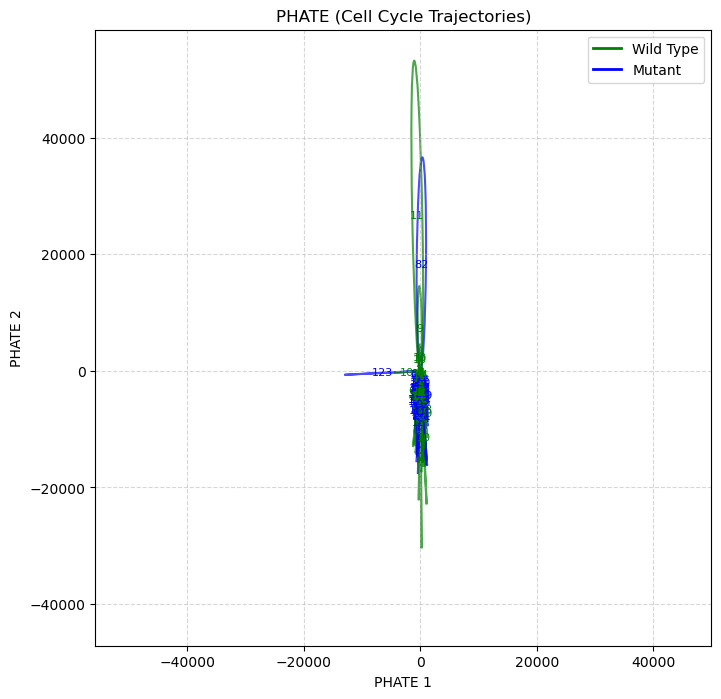

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
import ast

df = pd.read_csv('/scratch/leuven/359/vsc35907/big_data_feature_extraction/results/phate_plots/outliers_included/aperture_results.csv', sep=',')

# Convert the center string to a tuple of floats
df['center'] = df['center'].apply(ast.literal_eval)

# Create a figure
fig, ax = plt.subplots(figsize=(10, 8))

# Define colors for each label (0 and 1)
colors = {0: 'green', 1: 'blue'}

# Plot each ellipse
for idx, row in df.iterrows():
    center = row['center']
    width = 2 * row['semi_major_axis']  # total width is 2*semi_major
    height = 2 * row['semi_minor_axis']  # total height is 2*semi_minor
    angle = row['rotation_angle_deg']
    
    # Create the ellipse patch
    ellipse = Ellipse(xy=center, width=width, height=height, angle=angle,
                      edgecolor=colors[row['label']], facecolor='none',
                      alpha=0.7, linewidth=1.5)
    
    ax.add_patch(ellipse)
    
    # Add a label for the group
    ax.text(center[0], center[1], str(row['group']), 
            color=colors[row['label']], ha='center', va='center', fontsize=8)

# Set axis labels and title
ax.set_xlabel('PHATE 1')
ax.set_ylabel('PHATE 2')
ax.set_title('PHATE (Cell Cycle Trajectories)')

# Set equal aspect ratio
ax.set_aspect('equal')

# Calculate the range for both axes to make them identical
x_centers = [row['center'][0] for _, row in df.iterrows()]
y_centers = [row['center'][1] for _, row in df.iterrows()]
x_min, x_max = min(x_centers), max(x_centers)
y_min, y_max = min(y_centers), max(y_centers)

# Add padding to account for ellipse sizes
padding = max(max(row['semi_major_axis'], row['semi_minor_axis']) for _, row in df.iterrows()) * 1.2
x_range = (x_min - padding, x_max + padding)
y_range = (y_min - padding, y_max + padding)

# Find the largest range and apply it to both axes
max_range = max(x_range[1] - x_range[0], y_range[1] - y_range[0]) / 2
x_mid = (x_range[1] + x_range[0]) / 2
y_mid = (y_range[1] + y_range[0]) / 2

ax.set_xlim(x_mid - max_range, x_mid + max_range)
ax.set_ylim(y_mid - max_range, y_mid + max_range)

# Create legend
from matplotlib.lines import Line2D
legend_elements = [Line2D([0], [0], color='green', lw=2, label='Wild Type'),
                   Line2D([0], [0], color='blue', lw=2, label='Mutant')]
ax.legend(handles=legend_elements)

# Show the plot
plt.grid(True, linestyle='--', alpha=0.5)
plt.savefig('/scratch/leuven/359/vsc35907/feature_extraction_data/results/phate_plots/phate_elipses.png', bbox_inches='tight', dpi=300)
plt.show()

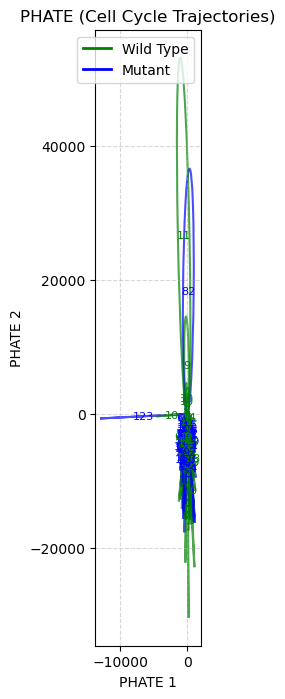

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
import ast

df = pd.read_csv('/scratch/leuven/359/vsc35907/big_data_feature_extraction/results/phate_plots/outliers_included/aperture_results.csv', sep=',')

# Convert the center string to a tuple of floats
df['center'] = df['center'].apply(ast.literal_eval)

# Create a figure
fig, ax = plt.subplots(figsize=(10, 8))

# Define colors for each label (0 and 1)
colors = {0: 'green', 1: 'blue'}

# Plot each ellipse
for idx, row in df.iterrows():
    center = row['center']
    width = 2 * row['semi_major_axis']  # total width is 2*semi_major
    height = 2 * row['semi_minor_axis']  # total height is 2*semi_minor
    angle = row['rotation_angle_deg']
    
    # Create the ellipse patch
    ellipse = Ellipse(xy=center, width=width, height=height, angle=angle,
                      edgecolor=colors[row['label']], facecolor='none',
                      alpha=0.7, linewidth=1.5)
    
    ax.add_patch(ellipse)
    
    # Add a label for the group
    ax.text(center[0], center[1], str(row['group']), 
            color=colors[row['label']], ha='center', va='center', fontsize=8)

# Set axis labels and title
ax.set_xlabel('PHATE 1')
ax.set_ylabel('PHATE 2')
ax.set_title('PHATE (Cell Cycle Trajectories)')

# Set equal aspect ratio
ax.set_aspect('equal')

# Create legend
from matplotlib.lines import Line2D
legend_elements = [Line2D([0], [0], color='green', lw=2, label='Wild Type'),
                   Line2D([0], [0], color='blue', lw=2, label='Mutant')]
ax.legend(handles=legend_elements)

# Adjust the plot to fit all ellipses
ax.autoscale_view()

# Show the plot
plt.grid(True, linestyle='--', alpha=0.5)
plt.savefig('/scratch/leuven/359/vsc35907/feature_extraction_data/results/phate_plots/phate_elipses.png', bbox_inches='tight', dpi=300)
plt.show()

#### Pair Plot Fitted Elipses data variables 

In [ ]:
# Read the CSV file
df = pd.read_csv('/scratch/leuven/359/vsc35907/big_data_feature_extraction/results/phate_plots/aperture_results.csv', sep=',')

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


# Drop only 'batch' and 'group', keep 'label' for coloring
df = df.drop(columns=['batch', 'group'])

# Create a scatter matrix with points colored by 'label'
sns.pairplot(df, hue='label')
plt.suptitle('Scatter Matrix of Variables Colored by Label', y=1.02)
plt.show()